# `[8] GAN`

`-` CNN 과 RNN 후에 많은 연습할 알고리즘이 있지만 이 책에서는 CRNN 만 다루고 있고 이미 다뤄본 알고리즘이라 바로 GAN 만 다루고 끝내겠습니다. <br>
`-` 무엇보다 가볍게 다루기 때문에 가볍게 보고 지나치겠습니다.

## `GAN 오토인코더`
- 현재 사진을 합성하는 기술로 존재하지 않는 사람을 그럴 듯 하게 만들 수 있는 기술
- GAN = 생성적 적대 신경망 `( Generative Adversarial Networks)` ([간])
- 매번 듣는 것 : 경찰과 도둑

`[1] 생성자`: 가상의 이미지로 공장을 만듭니다.
- 1.DCGAN 은 생성자가 가짜 이미지를 만들 때 CNN 을 이용 (앞에서 배운 CNN 과 원리가 다른 것이 optimizer 를 사용하는 최적화 과정과 컴파일 과정 이 존재 x, 그리고 풀링과정도 없지만 패딩이 존재 => 입력과 출력을 맞춰주기 위해)
- 2. 패딩으로 진짜와 똑같은 크기를 만들수 있다. ( keras 에서는 padding = 'same' 설정이 가능)
- 3. 배치정규화(Batch Normalization) 과정 : 데이터의 평균이 0 , 분산이 1이 되도록 재배치하기. 층의 개수가 늘어나도 안정적인 학습 가능 (`In keras` : `BatchNormalization()` )
- 4. ReLU() 함수로 판별자 넘겨주기. tanh()로 판별자 전 -1~1 사이로 크기 맞춰주기


>

<br>

# `MNIST 의 예시 GAN`

# [1] `생성자 생성함수`
```python
generator = Sequential()
generator.add(Dense(128*7*7 , input_dim=100 , activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7,7,128)))
generator.add(UpSampling2D()) # ...(1)
generator.add(Conv2D(64,kernel_size=5,padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D()) # ...(2)
generator.add(Conv2D(1, kernel_size=5,padding='same',activation='tanh'))
```

1. 
---
```python
generator.add(Dense(128*7*7 , input_dim=100 , activation=LeakyReLU(0.2)))
```
---

128 은 임의의 노드 숫자 : 굳이 128 이 아니여도 됩니다.
<br>
input_dim = 100 도 적절한 숫자 넣으면됩니다.
>
---
**`7*7`** : 이미지의 최소 크기를 의미 , MNIST 의 이미지는 `28*28` 인데 왜 최소크기 `7*7` 일까요 ?
-> 그 이유는 위의 (1) 과 (2) 의 UpSampling 때문입니다. UpSampling 은 이미지를 가로,세로로 2배씩 늘려줍니다. 그래서 `7*7` => `14*14` => `28*28` 이 됩니다. 

---
### `계속된 UpSampling` 사이에 `CNN` 을 적용시키는 작업을 하는 것이 `DCGAN` 의 특징입니다.

>

2. 
---
```python
generator.add(Reshape((7,7,128)))
```
- Convoultion layer 가 받아들일 수 있도록 형태를 정해줍니다.

<br>

## 3. 

```python
generator.add(UpSampling2D()) # ...(1)
generator.add(Conv2D(64,kernel_size=5,padding='same'))
```
<br>
5x5 커널을 사용하였고 padding 을 자동으로 조절하여 크기에 변화가 없도록 처리하였습니다.

>
이 후 3x3 커널도 같은 작업으로 크기를 조절하였습니다.

4. 
---
```python
generator.add(Dense(128*7*7 , input_dim=100 , activation=LeakyReLU(0.2))) 
generator.add(Activation(LeakyReLU(0.2)))
```
>

- LeakyReLU 의 형태를 보면 
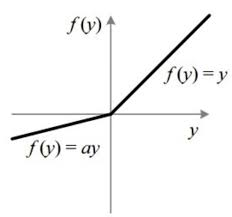

로 x 값이 음수일 때 무조건 0 이 되어 뉴런이 일찍 소실되는 단점을 보완하였습니다. 0.2 는 0보다 작을경우 0.2 를 곱하라는 의미입니다.

# [2] `판별자 ,진위를 가려내는 장치`

- CNN (컨볼루젼 신경망) 은 구별에 최적화된 알고리즘입니다. 목적 그대로 사용합니다. 진짜 = 1 ,가짜 = 0
- 이전 장에서 배운 compile 내부의 binary_crossentropy ,adam , Dropout(0.3) ,batch_normalization , padding 등 모두 넣습니다.
<br>

### `-` [2] **`판별자`** 의 진심 : 진짜인지 가짜인지 판별만해줄 뿐 자신이 학습을 하면 안된다!
<br>

- `판별자`가 얻은 가중치는 다시 생성자에게 넘겨주어 `생성자`가 `업데이트된 이미지 만들도록 해야함.`
  - 따라서 `판별자`를 만들 때 `가중치를 저장`하는 `학습기능 끄기`

# `판별자`의 코드
```python
discriminator = Sequential()
discriminator.add(Conv2D(64,kernel_size=5,strides=2,input_shape=(28,28,1),padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128,kernel_size=5,strides=2,padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1,activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy',optimizer='adam')
discriminator.trainable=False
```

>

[해석]
- 간단히 64 개의 node 에서 128 개의 node 로 높였고 그 사이사이 알고있는 코드가 등장했습니다.
- Flatten 으로 노드들을 폈고 Dense 1 로 fullyconnected 를 받았습니다. sigmoid 로 확률로 바꾸었고
- 판별자가 train 을 하지않고 결과를 계산한다고 했습니다.

>

<br>